# <center>Practical 09: Articulated Robots - Kinematics</center>

In [1]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3
from spatialmath.base.transforms3d import tr2delta
import numpy as np
import math
import pickle

from Practical09_Support.visualizer import *
from IPython.core.display import display

C:\Users\thean\AppData\Local\Temp\ipykernel_5744\1823053239.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# 5. Coding Exercise (7pts) : Inverse Kinematics

In this coding exercise, we will compute the sequence of joint configurations necessary to reach a desired end effector position using inverse kinematics. We will be using our 3dof manipulator

You are tasked with completing the following steps:
1. Compute end-effector transform using the current robot joint configuration ``robot.q`` by ``robot.fkine(.)``.
2. Compute error between target and the current positions of the end effector. We will use this position error to generate a velocity $\boldsymbol{\dot{X}}$ for the end-effector.
    - The attribute ``t`` of the variables ``current_ee`` and ``target`` gives you the position of the end effector and target in world coordinates
3. Compute the Jacobian at the current joint configuration. Use the function ``robot.jacob0(.)`` to get the Jacobian.
4. Compute the increment $\boldsymbol{\dot{q}}$. Since we are only considering the end effector position, we only need to compute the inverse of the linear velocity Jacobian. That is

\begin{equation}
\boldsymbol{\dot{q}} = J_{v, 3x3}^{-1} \boldsymbol{\dot{X}}
\end{equation}

5. Compute the new robot joint configuration using $\boldsymbol{\dot{q}}$, then update $\boldsymbol{q}$ and add it to *trajectory* using ``apend()``.
6. Update end-effector transform with updated joint positions.

Hint: Counsult https://petercorke.github.io/robotics-toolbox-python/index.html for methods such as ``fkine(.)`` and ``jacob0(.)``

In [13]:
def inverse_kinematics(robot, target, max_iterations=100, delta=0.1):
    """
    Compute sequence of joint configurations necessary to reach a desired end effector pose using inverse kinematics.
    :param robot (DHRobot): Robot object for which inverse kinematics will be computed
    :param target (SE3): Homogeneous transformation that describes desired position and orientation for the robot's end effector
    :param max_iterations (int): Max. number of inverse kinematics iterations
    :param delta (float): Update time step for integration
    
    :return List of 1xn arrays: Sequences joint configurations for robot with n joints
    """
    
    #TODO1: Get end-effector transform ------------
    current_ee = robot.fkine(robot.q)
    #ENDTODO --------------------------------------
    
    # Initialize counter and variable to cumulate joint trajectory
    counter = 0
    trajectory = [robot.q]
    
    
    while counter < max_iterations:
        # Get current q
        q = robot.q
        
        #TODO 2: Get error between end-effector and target
        x_dot = target.t - current_ee.t
        # Hint: print(target.t), print(current_ee.t)
        #ENDTODO --------------------------------------
        
        #TODO 3: Compute Jacobian
        J = robot.jacob0(q, half='trans')
        #ENDTODO --------------------------------------
        
        #TODO 4: Compute increment
        dq = np.linalg.inv(J)@x_dot
        #ENDTODO --------------------------------------
        
        #TODO 5: Update q and append trajectory
        q_new = q + dq*delta
        robot.q = q_new
        trajectory.append(q_new)
        
        #ENDTODO --------------------------------------
        
        #TODO 6: Update end-effector transform
        current_ee = robot.fkine(q_new)
        #ENDTODO --------------------------------------
        
        # Update counter
        counter += 1
    
    return trajectory  
    

### Test your implementation

For the target configuration ```SE3(1.37 , 0 , 1.37)``` and starting at configuration $\theta_1=0$, $\theta_2=90$, $\theta_3=-90$: 

- **Visually**: observe how our 3d-manipulator's end effector slowly approches the target
   - Hint: you could replace ``path_to_plot`` with ``seq_q`` in ``animate(.)`` for visulisation of example solution

- **Numerically**: compare the sequence of joints angles given by your method with the one provided in the test file ``Support/data/IK_TestCase.pk``: 

Is computed path close to solution?  True


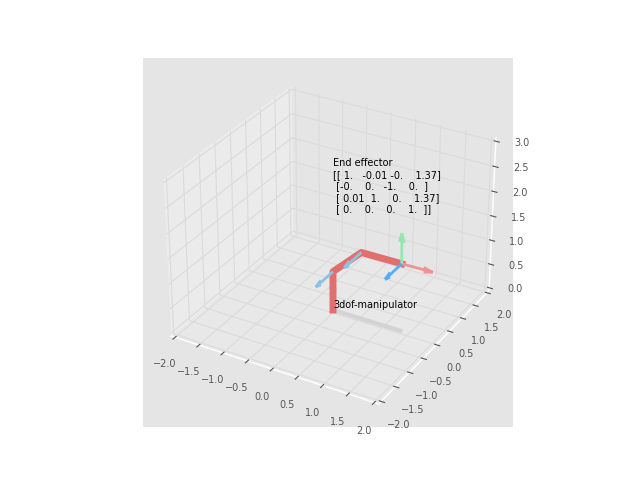

In [14]:
# Load test case and define variables
with open('Practical09_Support/pickle/IK_TestCase.pk', 'rb') as read_from:
    test_values = pickle.load(read_from)

seq_q = test_values['q_sequence']

# Initialising the robot parameters
link1 = RevoluteDH(d=0.8, a=0, alpha=np.pi/2)
link2 = RevoluteDH(d=0, a=0.8, alpha=0)
link3 = RevoluteDH(d=0, a=0.8, alpha=0)
my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')
# Define inital joint configuration and target end-effector position
my_bot.q = [0, np.pi/2, -np.pi/2]
target = SE3(1.37 , 0 , 1.37)

# Compute the sequence of joint configurations
path_to_plot = inverse_kinematics(my_bot, target)

# Visulisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)

my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
my_plot.draw()

def init():
    my_plot.draw()
    return
def animate(i):
    # replace the following three occurence of path_to_plot by seq_q to visulise the solution
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)

# Numerical comparison
print('Is computed path close to solution? ',np.all(np.isclose(path_to_plot, seq_q)))

# Grading

We will give you publicly 2 out of 5 test cases that we run to mark you (we will release the rest when all the submissions are made). Since this exercise takes up 7 points, you will get 1.4 point for passing each scenario. The difference between scenarios is simply the `initial_q` and `target`. Meaning if you are not passing these following test cases, you will receive zero, if you pass all the following test cases, you will get at least 2.8 / 7 when I grade on my machine.

**For your submission**: Make sure that you do not change the signature of the ``inverse_kinematics`` function. Verify that your code returns the expected output (i.e. list of 1 x n np.arrays)

In [15]:
import otter
grader = otter.Notebook(tests_dir = "Practical09_Support/tests")
grader.check_all()

ik_accuracy results: All test cases passed!
ik_accuracy - 1 message: passing from [ 0., pi/6, -pi/6] to [0., 0., 2.4]
ik_accuracy - 2 message: passing from [0., 0., pi/4] to [-0.009, 0., 1.93 ]